#### Installation des librairies

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 12.2 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.2
    Uninstalling matplotlib-3.9.2:
      Successfully uninstalled matplotlib-3.9.2
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install pandoc

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34821 sha256=d0b9a8c70710b0e9bd485d50e31f30a4bcd1d60346581baf19dc64a6f7b4a64f
  Stored in directory: c:\users\bette\appdata\local\pip\cache\wheels\9c\2f\9f\b1aac8c3e74b4ee327dc8c6eac5128996f9eadf586e2c0ba67
Successfully built pandoc
Note: you may need to restart the kernel to use updated packages.


#### Chargement des librairies

In [1]:
import numpy as np
import random
import math as m
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

#### Contexte théorique de l'étude

Considérons l'ensemble des données cibles $D_{T}=\{X_{T},Y_{T}\}$ tel que $Y_{T}=X_{T}\beta_{T} + \epsilon_{T}$ où $Y_{T}=(y_{1},.....,y_{N_{T}})$ désigne le vecteur réponse de taille $N_{T}$, $X_{T}$ $\in$ $\mathbb{R}^{N_{T}\times{D}}$ la matrice de conception avec D prédicteurs (incluant l'intercepte) et $\epsilon_{T} \sim \mathcal{N}(0,\sigma_{T}^{2}\mathbb{I}_{N_{T}})$ le vecteur iid de bruit gaussien. 
De même on considère l'ensemble des données sources $D_{S}=\{X_{S},Y_{S}\}$ tel que $Y_{S}=X_{S}\beta_{S} + \epsilon_{S}$  où $Y_{S}=(y_{1},.....,y_{N_{S}})$ désigne le vecteur réponse de taille $N_{S}$, $X_{S}$ $\in$ $\mathbb{R}^{N_{S}x{D}}$ la matrice de conception avec D prédicteurs (incluant l'intercepte) et $\epsilon_{S} \sim \mathbb{N}(0,\sigma_{S}^{2}\mathbb{I_{N_{S}}})$ le vecteur iid de bruit gaussien. Le nombre de données sources est considéré beaucoup plus élevé que celui des données cibles : $N_{S} \gg N_{T}$.
Les estimateurs respectifs des moindres carrés (OLS) pour les deux taches de régressions sont : 

$\hat{\beta}_{T}=(X_{T}^\top X_{T})^{-1}X_{T}^\top Y_{T} \ \ \text{et} \ \ \hat{\beta}_{S}=(X_{S}^\top X_{S})^{-1}X_{S}^\top Y_{S}$ 


et la prédiction pour un nouvel échantillons $\boldsymbol{x}$ issues de l'ensemble cible serait $$\hat{y}=\boldsymbol{x}^\top\hat{\beta}_{T}$$ 
Cependant la taille de l'ensemble cible étant très petit pour offrir de bonnes prédictions, utiliser les données sources en plus grande quantité 
pourrait compenser le manque de données cibles si la distance entre les données sources et cibles n'est pas trop importante . 
L'idée sera donc de vouloir construire un estimateur par transfert de connaissances $\hat{\beta}_{TL}$ tel que l'erreur de prédiction obtenu avec cet 
estimateur sera plus faible que celle obtenu avec l'estimateur de la cible seule $\hat{\beta}_T$ :

$\mathcal{R}(\hat{y}_{TL})=\mathbb{E}[(y - \hat{y}_{TL})^{2}] <  \mathcal{R}(\hat{y}_{T})=\mathbb{E}[(y - \hat{y}_{T})^{2}]$.

Nous verrons dans ce travail qu'il est possible de construire un tel estimateur des coefficients de régression puis nous montrerons comment est mis en 
oeuvre le test permettant de choisir l'estimateur le mieux adapté pour un nouvel échantillon $\boldsymbol{x}$ de issues des données tests.
Dans la suite on pose $\sum_{\nu}=X_{\nu}^\top X_{\nu}$ inversible avec $X_{\nu}$ $(\nu \in \{S,T\})$.

#### Gain du transfert

Pour construire l'estimateur par transfert on procède par fine-tuning. L'idée est de partir de l'estimateur sources $\hat{\beta}_{S}= \sum_{S}^{-1}X_{S}Y_{S}$ 
et d'effectuer une descente de gradient (DG) de taille de pas $\alpha$ sur l'objectif des moindres carrés $J_T(\beta)=\frac{1}{2}\lVert Y_T - X_T\beta\rVert^{2}$.
Intuitivement, l'idée est donc d'incorporer les quelques échantillons cibles disponibles à la source comme base. A l'itération $k \in \mathbb{N}$ 
de la descente de gradient, l'estimateur de $\beta_{T}$ obtenu par fine-tuning est une combinaison matricielle des estimateurs sources et cibles donné 
par : 

$\hat{\beta}_{k}=A^{k}\hat{\beta}_{s} + (\mathbb{I}_D - A^{k})\hat{\beta}_{T}$

où $A=\mathbb{I} - \alpha \sum_{T}$ et $\alpha$ le pas de descente de la DG. On définit par $\mathbb{M}_{k}$ le modèle associé à l'estimateur
$\hat{\beta}_k$ et par $\mathbb{M}_T$ le modèle associé à l'estimateur $\hat{\beta}_T$. Ensuite pour savoir si le modèle $\mathbb{M}_{k}$ était 
meilleur que le modèle cible pur $\mathbb{M}_{T}$ il a été défini une quantité appelé le gain du transfert défini par : $$\Delta R_{k}(\boldsymbol{x}) = \mathbb{E} [(y - \hat{y}_{T})^{2}] - \mathbb{E}[(y - \hat{y}_{k})^{2}]$$ avec $\hat{y}_{T}=\boldsymbol{x}^\top\hat{\beta}_{T}$ et $\hat{y}_{k}=\boldsymbol{x}^\top\hat{\beta}_{k}$. 
En exprimant correctement les lois des expressions dans les espérances, on peut montrer que le gain à l'itération k de la DG  se réécrit : 

$$\Delta R_{k}(\boldsymbol{x})=\boldsymbol{x}^T H_{k}\boldsymbol{x}$$ avec 

$H_k = \sigma^2_T (\sum_T^{-1} - \alpha^2 \Omega_{k} \sum_T \Omega_k) - \sigma^2_S A^{k} \sum_S^{-1} A^{k} - A^{k} B A^{k}$

$\Omega_k = \frac{1}{\alpha} \sum^{-1}_T (\mathbb{I}_{D} - A^{k})$ et $B=(\beta_T - \beta_s )(\beta_T - \beta_s)^{T}$

Cette quantité, à savoir le gain, devrait nous permettre de savoir pour chaque $\boldsymbol{x}$ de l'échantillon cible test s'il est préférable 
d'utilisé l'estimateur par transfert pour la prédiction au lieu de l'estimateur cible pure. Typiquement si le gain est positif, il est préférable 
d'utiliser l'estimateur par transfert et dans ce cas on dit que le transfert est bénéfique pour un nouvel $\boldsymbol{x}$, dans le cas contraire 
le transfert est négatif.
Toutefois on constate qu'en pratique cette quantité à elle toute seule ne nous apporte pas beaucoup d'informations car certaines quantités comme 
$\beta_{\nu}$  $\nu \in (S,T)$ ou $\sigma_{\nu}^{2}$ $\nu \in (S,T)$ nous sont inconnues. Par conséquent un test d'hypothèse basé sur le gain sera 
réalisé afin de déterminer quel estimateur utilisé pour la prédiction. Pour chaque observation individuelle $\boldsymbol{x}$ de l'échantillon cible 
test, le test décidera de l'estimateur à utiliser pour prédire la réponse.

#### Estimation des coefficients d'un polynome

On considère ci-dessous le problème d'estimation des coefficients d'un  polynome cible.
Pour commencer, nous considérons les données cibles définies telles que les valeurs du vecteur réponse cible soient données par : 

$$y_{T,i}=P_T(x_{T,i}) + \epsilon_{T,i} \ \  pour \ \ i=1,....,N_T=20,$$ avec $x_{T,i}$ pris aléatoirement dans $[-3,1], \epsilon_{T,i} \sim \mathcal{N}(0,\sigma_T^{2})$ pour $ \sigma_T^{2}=0.5$ 
et $$P_T(x_{T,i})=\beta_{T,0} + \beta_{T,1}x_{T,i} + \beta_{T,2}x_{T,i}^{2} +   \beta_{T,3}x_{T,i}^{3}$$.

Cela nous donne réécrit sous forme matricielle : 

$$Y_T=X_T\beta_T + \epsilon_T$$ avec 


$Y_T=(y_{T,1},...,y_{T,i},...,y_{T,N_T})^{T}$,  $\beta_T=(\beta_{T,0},\beta_{T,1},\beta_{T,2},\beta_{T,3})^{T} = (-1,-1.8,1.2,1)^{T}$, 

$\epsilon_T=(\epsilon_{T,1},...,\epsilon_{T,i},...,\epsilon_{T,N_T})$ et 

 $$X_T= \begin{bmatrix}1&x_{T,1}&x_{T,1}^{2}&x_{T,1}^{3}\\
    1&x_{T,2}&x_{T,2}^{2}&x_{T,2}^{3}\\ \vdots&\vdots&\vdots&\vdots\\1&x_{T,N_T - 1}&x_{T,N_T - 1}^{2}&x_{T,N_T - 1}^{3}\\1&x_{T,N_T}&x_{T,N_T}^{2}&x_{T,N_T}^{3} \end{bmatrix}.  $$

Ensuite, pour les données sources, nous avons : $$y_{S,i}=P_S(x_{S,i}) + \epsilon_{S,i} \ \ pour \ \ i=1,....,N_S=100$$ avec $x_{S,i}$ pris aléatoirement dans $[0,3]$, $\epsilon_{S,i} \sim \mathcal{N}(0,\sigma_S^{2})$ pour $ \sigma_S^{2}=0.5$. \\Les coefficients de $P_S$ sont les mêmes que ceux de $P_T$ plus un bruit gaussien de moyenne nulle et d'écart type 0.3. Donc : $$\beta_S=(\beta_{T,0} + \mathcal{N}(0,0.3^{2}),\beta_{T,1} + \mathcal{N}(0,0.3^{2}),\beta_{T,2} + \mathcal{N}(0,0.3^{2}),\beta_{T,3} + \mathcal{N}(0,0.3^{2}))^{T}.$$ Et alors : $$P_S(x_{S,i})=\beta_{T,0} + \mathcal{N}(0,0.3^{2}) + (\beta_{T,1} + \mathcal{N}(0,0.3^{2}))x_{T,i} + (\beta_{T,2} + \mathcal{N}(0,0.3^{2}))x_{T,i}^{2} +   (\beta_{T,3} + \mathcal{N}(0,0.3^{2}))x_{T,i}^{3}. $$
 Ce qui nous donne sous forme matricielle : $$Y_S=X_S\beta_S + \epsilon_S$$ avec $Y_S=(y_{S,1},...,y_{S,i},...,y_{S,N_S})^{t}$, $\epsilon_S=(\epsilon_{S,1},...,\epsilon_{S,i},...\epsilon_{S,N_S})^{t}$  et\\ $$X_S= \begin{bmatrix}1&x_{S,1}&x_{S,1}^{2}&x_{S,1}^{3}\\
    1&x_{S,2}&x_{S,2}^{2}&x_{S,2}^{3}\\ \vdots&\vdots&\vdots&\vdots\\1&x_{S,N_S - 1}&x_{S,N_S - 1}^{2}&x_{S,N_S - 1}^{3}\\1&x_{S,N_S}&x_{S,N_S}^{2}&x_{S,N_S}^{3} \end{bmatrix}  .$$

#### Modèle de régression cible

In [2]:
#conception of the target model
Nt=20
D=4
sigma_t=0.5
betat0=-1
betat1=-1.8
betat2=1.2
betat3=1
X_t=np.ones((Nt,D))
x_t=np.ones((Nt,1))
random.seed(a=256, version=2)
for i in range(0,Nt):
    x_t[i,0]=-4*random.random()+1
for j in range(1,D):
    for i in range(0,Nt):
        if j==1:
            X_t[i,j]=x_t[i,0]
        elif j==2:
            X_t[i,j]=(x_t[i,0])**2
        else:
            X_t[i,j]=(x_t[i,0])**3
big_sigma_t=np.matmul(np.transpose(X_t),X_t)
random.seed(a=255, version=2)
epsilon_t=np.ones((Nt,1))
for i in range(Nt):
    epsilon_t[i,0]=random.normalvariate(mu=0.0, sigma=m.sqrt(sigma_t))
beta_t=np.array([[betat0],[betat1],[betat2],[betat3]])
Y_t=X_t@beta_t+epsilon_t

#### Modèle de régression source

In [3]:
#conception of the source model
Ns=100
D=4
sigma_s=0.5
X_s=np.ones((Ns,D))
x_s=np.ones((Ns,1))
random.seed(a=254, version=2)
for i in range(0,Ns):
    x_s[i,0]=3*random.random()
for j in range(1,D):
    for i in range(0,Ns):
        if j==1:
            X_s[i,j]=x_s[i,0]
        elif j==2:
            X_s[i,j]=(x_s[i,0])**2
        else:
            X_s[i,j]=(x_s[i,0])**3
big_sigma_s=np.matmul(np.transpose(X_s),X_s)
random.seed(a=253, version=2)
epsilon_s=np.ones((Ns,1))
for i in range(Ns):
    epsilon_s[i,0]=random.normalvariate(mu=0.0, sigma=m.sqrt(sigma_s))
    
random.seed(a=252, version=2)
beta_s=np.array([[betat0 + random.normalvariate(mu=0.0, sigma=0.3)],[betat1 +random.normalvariate(mu=0.0, sigma=0.3) ],[betat2 + random.normalvariate(mu=0.0, sigma=0.3) ],[betat3 + random.normalvariate(mu=0.0,sigma=0.3) ]])
Y_s=X_s@beta_s+epsilon_s

#### Choix des paramètres du modèle

Après avoir définies les modèles et simulées les données comme fait précédemment, nous allons à présent choisir le paramètre $k$, qui, rappelons-le, 
représente le nombre d'itérations de la DG.

Deux méthodes sont proposées pour déterminer le paramètre $k$.

La première méthode est de procéder par cross-validation leave-one-out (LOOCV). Pour ce faire On considère 

$D^{(-i)}_{T}=(X^{(-i)}_{T},Y^{(-i)}_{T})$ et $D^{(-i)}_{S}=(X^{(-i)}_{S},Y^{(-i)}_{S})$ 

qui représente les ensembles de données sources et cibles où on a retiré l'observation $i$. Le notation $(-i)$ corresponds au retrait de l'observation 
$i$. Ensuite on calcul les estimateurs $\hat{\beta}^{(-i)}_T$, $\hat{\beta}^{(-i)}_S$ et $\hat{\beta}^{(-i)}_k$ correspondants. Le nombre d'itération 
$k$ est alors pris comme celui maximisant l'erreur LOOCV défini par : 
$$(1/N_T)\times\sum_{i=1}^{N_T} (Y_T^{(i)} -\hat{Y}_T^{(i)})^{2} - (Y_T^{(i)} -\hat{Y}_k^{(i)})^{2}$$ où  $\hat{Y}_T^{(i)}$ 
est l'estimation de l'observation réponse $i$, estimé en utilisant $\hat{\beta}^{(-i)}_T$ \\ et $\hat{Y}_k^{(i)}$ l'estimation de l'observation réponse 
$i$ mais cette fois estimé en utilisant $\hat{\beta}^{(-i)}_k$. 

Dans la seconde méthode $k$ est sélection comme celui maximisant la quantité: 

$$\bar{U}_k=\frac{1}{N_S + N_T} \sum_{i=1}^{N_S + N_T}U_{k}(x_{i})$$ avec  $U_{k}(x)=\sigma_T^{2} x^{T} \sum_T^{-1}xln(\frac{x^{T} V_k x}{\sigma_T^{2} x^{T} \sum_T^{-1} x})$ 

le second terme de $\Delta R_{k}(\boldsymbol{x})$ et  $V_{k} = \sigma_S^{2} A^{k} \sum_S^{-1} A^{k} + \sigma_T^{2}\alpha^{2}\Omega_k \sum_T \Omega_K$ 

où les vraies variances sont remplacées par leur équivalent empiriques.

Pour les deux méthode, dans le cas de l'absence d'un maximum, la règle du coude est appliquée à la place. La p-valeur du test $p_k(\boldsymbol{x}) \to 0$ lorsque $k \to \infty$, 
un choix résonnable de $k$ est d'une importante capitale car lorsque $k$ va vers l'infini le test rejettera presque systématiquement l'hypothèse 
nulle malgré le fait que le gain converge vers 0.


Ici nous avons effectué les deux méthodes. La méthode par maximisation de $\bar{U}_k$ et celle de l'erreur 
LOOCV. Nous en illustrons les résultats ci-après.

En l'absence de maximum sur l'une des méthodes, on utilise la règle du coude, cependant ici on constate que la méthode par LOOCV nous fourni un maximum 
atteint en k=39. On choisi donc 39 comme notre nombre d'itérations de gradient. En ce qui concerne les autres paramètres, $\alpha$ a été pris à 
$\frac{\alpha^{*}}{2}$ avec $\alpha^*=\frac{2}{\lambda_{max}(\sum_T) + \lambda_{min}(\sum_T)}$, tout en vérifiant que la condition $0<\alpha<\frac{1}{\lambda_{max}(\sum_T)}$ était bien respecté. La valeur de $\alpha$ était 
$\alpha=0.0088$ et $\rho$ a été pris dans la plage de $10^{-5}$ à $1$. Il a été pris à $\rho=0.5$. 



#### Choix de $k$ par maximisation de $\bar{U}_k$

In [ ]:
#separate the data betwenn , train set and test set
X_t_train=X_t[0:10,:]
Y_t_train=Y_t[0:10]
Nt_train=np.shape(X_t_train)[0]
X_t_test=X_t[10:21,:]
Y_t_test=Y_t[10:21]
Nt_test=np.shape(X_t_test)[0]
big_sigma_t_train=np.matmul(np.transpose(X_t_train),X_t_train)
##choice of alpha
alpha_etoile=2/( np.max(np.linalg.eigvals(big_sigma_t_train)) + np.min(np.linalg.eigvals(big_sigma_t_train)) )
alpha=alpha_etoile/2
#maximization of Uk_barre
L=[]
Uk=np.ones(Ns+Nt_train)
A=np.eye(D) - alpha*big_sigma_t_train
def matrix_power_diagonalization_stable(A, k):
    #Obtenir les valeurs propres et les vecteurs propres de A
    eigenvalues, eigenvectors = np.linalg.eig(A)
    #Calculer la matrice diagonale des valeurs propres élevées à la puissance k
    D_k = np.diag(np.exp(k*np.log(eigenvalues)))
    # Calculer A^k = P D^k P^-1
    A_k = eigenvectors @ D_k @ np.linalg.inv(eigenvectors)
    return A_k
for k in range(1500):
    A_k=matrix_power_diagonalization_stable(A,k)
    omegak=(1/alpha)*np.linalg.inv(big_sigma_t_train)@(np.eye(D) - A_k)
    Vk=(sigma_s**2)*(A_k)@(np.linalg.inv(big_sigma_s))@(A_k) +(sigma_t**2)*(alpha**2)*(omegak)@(big_sigma_t_train)@(omegak)
    for i in range(Ns):
        Uk[i]=(sigma_t**2)*np.transpose(X_s[i,:])@np.linalg.inv(big_sigma_t_train)@X_s[i,:]*m.log( (np.transpose(X_s[i,:])@Vk@X_s[i,:])/ ( (sigma_t**2)*np.transpose(X_s[i,:])@np.linalg.inv(big_sigma_t_train)@X_s[i,:] ))
    for i in range(Ns,Ns+Nt_train):
        Uk[i]=(sigma_t**2)*np.transpose(X_t_train[i-Ns,:])@np.linalg.inv(big_sigma_t_train)@X_t_train[i-Ns,:]*m.log( (np.transpose(X_t_train[i-Ns,:])@Vk@X_t_train[i-Ns,:]) / ( (sigma_t**2)*np.transpose(X_t_train[i-Ns,:])@np.linalg.inv(big_sigma_t_train)@X_t_train[i-Ns,:]) )
    Uk_barre=0
    for i in range(len(Uk)):
        Uk_barre+=(1/(Ns+Nt_train))*Uk[i]
    L.append(Uk_barre)
        #Uk_barre=np.mean(Uk)
        #Uk_barre=np.mean(Uk)
        #L.append(Uk_barre)
print(L.index(max(L)))

L.pop(0)
plt.plot(L,label='Uk_barre')
#plt.axvline(x=1000,color='r',label='x = 200',linestyle='--')
#plt.axvline(x=180,color='r',label='x = 200',linestyle='--')
#plt.title('Uk_barre')
plt.xlabel('iterations de Gradient k')
plt.ylabel('Uk')
plt.legend()

#### Choix de $k$ par maximisation de l'erreur LOOCV (leave-one-out cross validation)

39


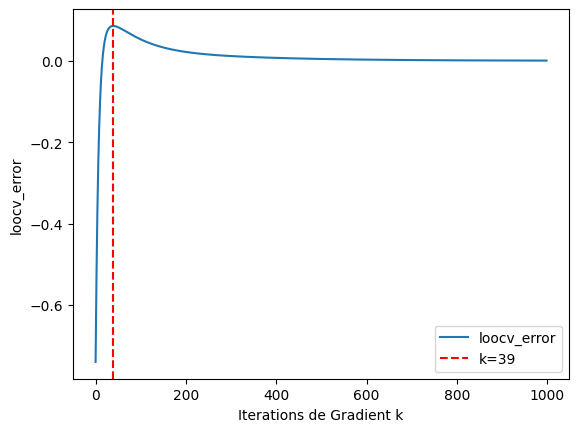

In [12]:
#maximizing of the LOOCV
Beta_t_chap_remove=np.ones((Nt_train,D))
for i in range(Nt_train):
    beta_t_chap_remove=np.ones(D)
    X_t_train_remove=np.delete(X_t_train, (i), axis=0)
    Y_t_train_remove=np.delete(Y_t_train, (i), axis=0)
    beta_t_chap_remove=np.linalg.inv( np.transpose(X_t_train_remove)@X_t_train_remove )@( np.transpose(X_t_train_remove)@Y_t_train_remove )
    Beta_t_chap_remove[i,:]=np.transpose(beta_t_chap_remove) # ou alors onutilise.squeeze()
    
Y_t_chap_cross_val=np.ones(Nt_train)
for i in range(Nt_train):
    Y_t_chap_cross_val[i]=np.transpose(X_t_train[i,:])@Beta_t_chap_remove[i,:]
    
Beta_s_chap_remove=np.ones((Nt_train,D))
for i in range(Nt_train):
    beta_s_chap_remove=np.ones((D))
    X_s_remove=np.delete(X_s, (i), axis=0)
    Y_s_remove=np.delete(Y_s, (i), axis=0)
    beta_s_chap_remove=np.linalg.inv( np.transpose(X_s_remove)@X_s_remove )@(np.transpose(X_s_remove)@Y_s_remove )
    Beta_s_chap_remove[i,:]=np.transpose(beta_s_chap_remove)
    
P=[]
S=[]
for k in range(1000):
    A_k=matrix_power_diagonalization_stable(A,k)
    Beta_k_chap_remove=np.ones((Nt_train,D))
    Y_k_chap_cross_val=np.ones(Nt_train)
    for i in range(Nt_train):
        beta_k_chap_remove=(A_k)@Beta_s_chap_remove[i,:] + ( np.eye(D)- A_k)@Beta_t_chap_remove[i,:]
        Beta_k_chap_remove[i,:]=beta_k_chap_remove
        Y_k_chap_cross_val[i]=np.transpose( X_t_train[i,:])@Beta_k_chap_remove[i,:]
    loocv_error_k=0
    for i in range(Nt_train):
        original_error=(Y_t_train[i]- Y_t_chap_cross_val[i])**2
        adjusted_error=(Y_t_train[i]-Y_k_chap_cross_val[i])**2
        loocv_error_k+=(1/Nt_train)*(original_error-adjusted_error)
    #print(loocv_error_k[0])
    P.append(loocv_error_k[0])
P.pop(0)
print(P.index(max(P)))
plt.plot(P,label='loocv_error')
plt.axvline(x=39,color='r',label='k=39',linestyle='--')
#plt.title('LOOCV_ERROR')
plt.xlabel('Iterations de Gradient k')
plt.ylabel('loocv_error')
plt.legend()

#### Tracé du polynome cible $P_t$ et ses estimations

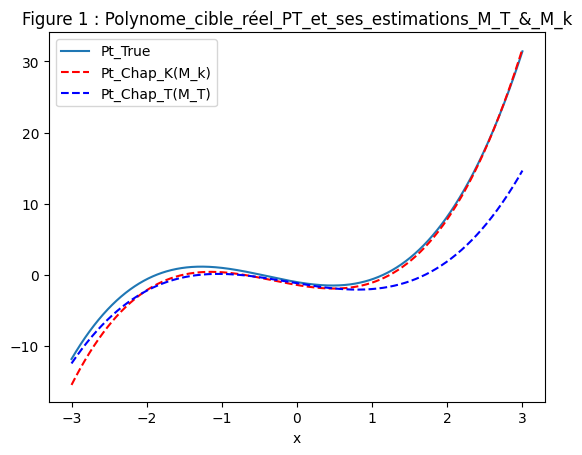

In [16]:
#Plot of the true polynomial Pt and its estimations P_t_chap and P_k_chap
k=P.index(max(P))
A_k = matrix_power_diagonalization_stable(A, k)
beta_t_chap=np.linalg.inv( np.transpose(X_t_train)@X_t_train )@( np.transpose(X_t_train)@Y_t_train )
beta_s_chap=np.linalg.inv( np.transpose(X_s)@X_s )@( np.transpose(X_s)@Y_s )
beta_k_chap=A_k@beta_s_chap + (np.eye(D) - A_k)@beta_t_chap
x = np.linspace(-3, 3,800 )
Pt_true = x**3 + (1.2)*x**2 + (-1.8)*x -1
Pt_chap=(beta_t_chap[3])*x**3 + (beta_t_chap[2])*x**2 + (beta_t_chap[1])*x +beta_t_chap[0]
Pt_chap_k=(beta_k_chap[3])*x**3 + (beta_k_chap[2])*x**2 + (beta_k_chap[1])*x +beta_k_chap[0]
plt.title('Figure 1 : Polynome_cible_réel_PT_et_ses_estimations_M_T_&_M_k')
plt.plot(x, Pt_true, label='Pt_True')
plt.plot(x, Pt_chap_k, color='red', linestyle='--', label='Pt_Chap_K(M_k)')
plt.plot(x, Pt_chap, color='blue', linestyle='--', label='Pt_Chap_T(M_T)')
plt.xlabel('x')
plt.legend()

Conformément à ce à quoi on s'attendait, sur la (Figure 1) on voit que le modèle cible $\mathbb{M}_T$ utilisant l'estimteur cible 
pure $\hat{\beta}_T$ est plutôt bon pour les $x\leq 0$ et très éloigné de la vrai courbe pour les $x>0$. Ce qui est normal car l'estimateur cible 
pure a été construit à partir de données $x$ prises dans $[-3,1]$, donc il contient essentiellement l'information relative à ce domaine. A l'inverse 
l'estimateur obtenu par transfert($\hat{\beta}_k$) performe pour les $x$ positif et fait approximativement aussi bien que l'estimateur cible pure pour 
les $x\leq 0$. On remarque également qu'à l'instar de l'estimateur cible pure qui est bon seulement pour les $x \leq 0$, l'estimateur par transfert 
essaie de bien se comporter sur les deux domaines. Ce qui est normal car il comporte les informations provenant des deux sources de données. 
Pour les $x>0$ il minimise fortement l'écart à la vrai courbe, comme attendu, car les données sources appartiennent à cet intervalle et sont 
suffisamment nombreuses pour permettre une bonne estimation (on rappelle que $N_{S} \gg N_{T}$). Pour les $x$ négatifs, on s'attendrait à ce qu'il 
fasse aussi bien que l'estimateur cible pure mais la forme du modèle et la part de biais introduite par la grande quantité de données sources pourraient
expliquer qu'il fasse juste un peu moins bien que la cible pure pour les $x\leq 0$. Toutefois,de manière globale, l'estimateur par transfert associé au
modèle $\mathbb{M}_k$ offre une meilleur estimation du polynôme $P_T$ que l'estimateur cible pure associé au modèle $\mathbb{M}_T$

#### Test de positivité du transfert et tracé des p-valeurs du test

On rappelle que le gain est défini par : $$\Delta R_{k}(\boldsymbol{x}) = \mathcal{R}(\hat{y}_{T}) - \mathcal{R}(\hat{y}_{k}) = \mathbb{E} [(y - \hat{y}_{T})^{2}] - \mathbb{E}[(y - \hat{y}_{k})^{2}].$$

Lorsque le gain est positif ($\Delta R_{k}(\boldsymbol{x}) >0 $) c'est à dire lorsque 

$\mathbb{E} [(y - \hat{y}_{T})^{2}] > \mathbb{E}[(y - \hat{y}_{k})^{2}]$, 

l'erreur de prédiction obtenu en utilisant le modèle $\mathbb{M}_k$ est plus faible que l'erreur de prédiction obtenu en utilisant le modèle

$\mathbb{M}_T$. Et dans l'autre sens, lorsque $\Delta R_{k}(\boldsymbol{x}) \leq 0 $ c'est à dire 

$\mathbb{E} [(y - \hat{y}_{T})^{2}] \leq \mathbb{E}[(y - \hat{y}_{k})^{2}]$, 

l'erreur de prédiction obtenu en utilisant le modèle $\mathbb{M}_k$ est plus grande que l'erreur de prédiction obtenu en utilisant le modèle 

$\mathbb{M}_T$. Donc lorsque le gain est positif on préférera choisir $\hat{\beta}_k$ pour les prédictions et lorsque le gain est négatif ou nul, 

on préférera utilisé $\hat{\beta}_T$ pour la prédiction. C'est sur ce principe qu'est basé notre test d'hypothèse, il nous permet de choisir entre 

les deux estimateurs pour chaque observations de l'échantillon cible test. L'hypothèse nulle $H_0$ correspond au choix de $\hat{\beta}_T$ tandis que 

l'hypothèse alternative $H_1$ correspond au choix de $\hat{\beta}_k$. Le test est formulé comme suit :
$$H_0 : \{\Delta R_{k}(\boldsymbol{x}) \leq 0\}\ \ VS \ \  H_1 : \{\Delta R_{k}(\boldsymbol{x})  > 0\}.$$ La zone de rejet du test est donnée par : 

$$R=\{ \psi_{k}(\boldsymbol{x}) > q^{1-a}\}$$ avec $$\psi_{k}(\boldsymbol{x})=\frac{\hat{\sigma}_T^{2}}{\hat{\sigma}_s^{2}}\frac{ \boldsymbol{x}^\top \left( \sum^{-1}_T - \alpha^2 \Omega_k \sum_T \Omega_k \right) \boldsymbol{x} - \rho^2 \|A^{k} \boldsymbol{x}\|^2}{ \boldsymbol{x}^\top A^{k} \sum^{-1}_S A^{k} \boldsymbol{x}},$$ $q^{1-a}$ le quantile d'ordre 1-a de la distribution de Fisher-Snedecor $F(N_{T} - D, N_{S} - D)$ de degrés de liberté $N_T - D$ et $N_S - D$, $a$ le niveau de significativité du test,  
$\hat{\sigma}_T^{2}$ et $\hat{\sigma}_S^{2}$ les estimations des bruits de variances défini par :
$\hat{\sigma}_\nu^2 = \frac{\|Y_{\nu} - X_{\nu} \hat{\beta}_{\nu}\|^2}{N_{\nu} - D}$  pour $\nu \in (S,T)$. 

La p-valeur des données observées est donnée par :

$p_k(\boldsymbol{x}) = \mathbb{P}_{F\sim F_{(N_T-D, N_S-D)}}\left(F \geq \psi_k(\boldsymbol{x})\right)$

Le test précédent nous permet de définir le modèle $M_k^*$. Le modèle $M_k^*$ est le modèle basé sur le test définit en utilisant les deux autres 
modèles. Il utilise le modèle $M_T$ si l'hypothèse nulle est gardée ($p_k(\boldsymbol{x}) > 0.05$) et le modèle $M_k$ dans le cas contraire.

In [20]:
#New test set, take to be gigger than the previous one (for plot the p-value)
Nz=100
z_t=np.ones((Nz,D))
z_t[:,1]=np.linspace(-3,3,Nz)
z_t[:,2]=np.linspace(-3,3,Nz)**2
z_t[:,3]=np.linspace(-3,3,Nz)**3
random.seed(a=255, version=2)
epsilon_t=np.ones((len(z_t),1))
for i in range(Nz):
    epsilon_t[i,0]=random.normalvariate(mu=0.0, sigma=m.sqrt(sigma_t))
Y_z=z_t@beta_t + epsilon_t

In [21]:
from scipy.stats import f
#Test for the positiveness of the transfer( and plot the pk_x)
k=39
A_k = matrix_power_diagonalization_stable(A, k)
omegak=(1/alpha)*np.linalg.inv(big_sigma_t_train)@(np.eye(D) - A_k)
p=np.median(np.linspace(10**(-5),1))
beta_t_chap=np.linalg.inv( np.transpose(X_t_train)@X_t_train )@( np.transpose(X_t_train)@Y_t_train )
beta_s_chap=np.linalg.inv( np.transpose(X_s)@X_s )@( np.transpose(X_s)@Y_s )
beta_k_chap=A_k@beta_s_chap + (np.eye(D) - A_k)@beta_t_chap
sigma_t_chap_carre=((np.linalg.norm(Y_t_train - X_t_train@beta_t_chap ,ord=2))**2) / (Nt_train-D)
sigma_s_chap_carre=((np.linalg.norm(Y_s - X_s@beta_s_chap , ord=2))**2) / (Ns-D)
Y_t_test_chap=np.ones(len(z_t))
s=0
y=np.ones(len(z_t))
for i in range(len(z_t)):
    phi_kx=(sigma_t_chap_carre)*( z_t[i,:]@(np.linalg.inv(big_sigma_t_train) -(alpha**2)*omegak@big_sigma_t_train@omegak)@np.transpose(z_t[i,:]) - (p*np.linalg.norm(A_k@np.transpose(z_t[i,:]), ord=2))**2 ) / ((sigma_s_chap_carre)*z_t[i,:]@A_k@np.linalg.inv(big_sigma_s)@A_k@np.transpose(z_t[i,:]) )
    p_kx=f.sf(phi_kx, Nt_train-D, Ns-D)
    y[i]=p_kx
    if p_kx<0.05:
        Y_t_test_chap[i]=(z_t[i,:]@beta_k_chap).item()
        s=s+1
    else:
        Y_t_test_chap[i]=(z_t[i,:]@beta_t_chap).item()
    #print(s)
for i in range(len(y)):
    if y[i]>0.05:
        y[i]=1
    else:
        y[i]=0

Pour examiner la validité du modèle $\mathbb{M}_k^{*}$, c'est à dire la véracité du test de positivité du transfert, il a été tracé les p-valeurs du 
test en fonction de $x$ afin de s'assurer qu'elles concordent avec les résultats précédents sur l'estimation du polynôme cible $P_T$. 
Dans la suite, les valeurs des p-valeurs du test ont été transformée de tel sorte qu'elles soient misent à $0$ pour les p-valeurs plus petite que 
$0.05$ et à $1$ pour celle plus grande. Une valeur de 0 indique que le test a rejeté l'hypothèse nulle, ce qui correspond au choix de l'estimateur 
$\hat{\beta}_k$ . À l'inverse, une valeur de 1 signifie que le test n'a pas rejeté l'hypothèse nulle, correspondant ainsi au choix de l'estimateur 
$\hat{\beta}_T$. Ces p-valeurs on ensuite été tracées. Si le test de positivé du transfert fonctionne bien alors les domaines avec une p-valeur basse 
devraient correspondre aux endroits où l'estimation par transfert était meilleur que l'estimation cible pur. À l'inverse les domaines où le tracé de 
la p-valeur est haute devraient correspondre aux endroits où l'estimation cible pure était meilleur. Nous en illustrons les résultats ci-après.

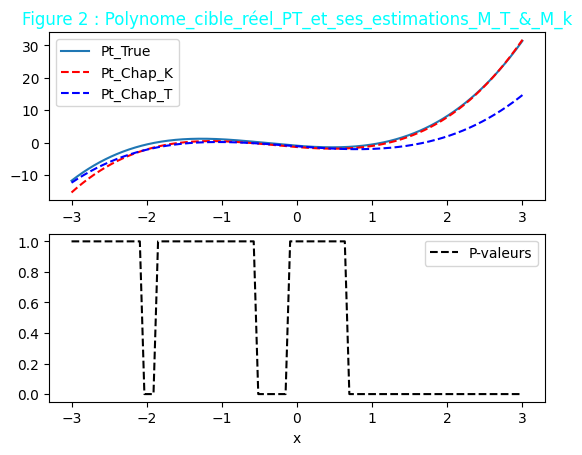

In [22]:
#plots the p-values of test
x = np.linspace(-3, 3, 800)
plt.subplot(211)
plt.title('Figure 2 : Polynome_cible_réel_PT_et_ses_estimations_M_T_&_M_k',color='cyan')
plt.plot(x, Pt_true, label='Pt_True')
plt.plot(x, Pt_chap_k, color='red', linestyle='--', label='Pt_Chap_K')
plt.plot(x, Pt_chap, color='blue', linestyle='--', label='Pt_Chap_T')
plt.legend()
x = np.linspace(-3, 3, 100)
plt.subplot(212)
plt.plot(x,y,color='black', linestyle='--', label='P-valeurs')
plt.xlabel('x')
plt.legend()

Comme attendu, le tracé de la p-valeur a tendance à être élevé  ( c'est a dire que l'hypothèse nulle est maintenue) pour les $x<0$ qui correspondent 
au domaine où l'estimation de la cible s'est bien comportée. En revanche dans le domaine où le modèle cible $\mathbb{M}_T$ s'est mal comporté et où 
$\mathbb{M}_k$ était proche du vrai polynôme $P_T$, la p-valeur est faible, ce qui confirme notre précédente analyse et valide le résultat du test de 
positivité du transfert. On peut aussi noter dans le domaine des $x<0$ deux petites plages de ce domaine où la p-valeur est faible, cela peut être 
attribué à l'importante proximité entre les deux modèles à ces endroits précis.
Par ailleurs, le modèle $\mathbb{M}_k^{*}$ basé sur le test offre des valeurs de prédictions plutôt proche des valeurs réelles, ce qui implique que 
le modèle à une bonne capacité de prédiction.

#### Tracé des valeurs de $Y_{prédit}$ du test en fonction des valeurs observées

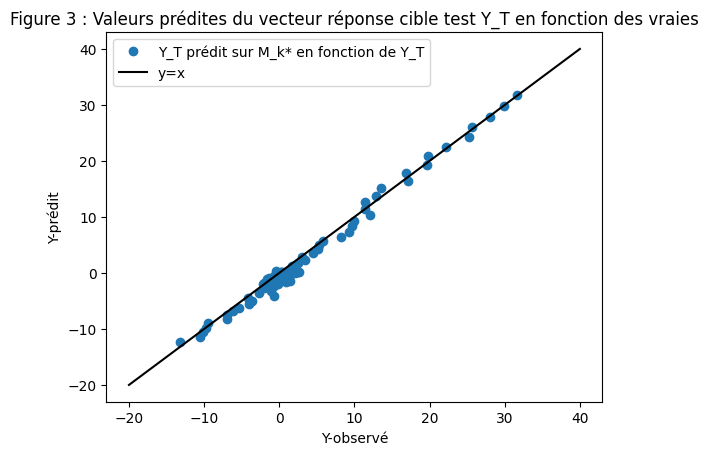

In [28]:
plt.title('Figure 3 : Valeurs prédites du vecteur réponse cible test Y_T en fonction des vraies')
plt.plot(Y_z,Y_t_test_chap,"o",label='Y_T prédit sur M_k* en fonction de Y_T')
plt.xlabel('Y-observé')
plt.ylabel('Y-prédit')
x = np.linspace(-20, 40, 100)
plt.plot(x,x,color='black',label='y=x')
plt.legend()